In [1]:
!python --version

Python 3.8.8


In [1]:
import statsmodels
print(statsmodels.__version__)

0.13.2


# Homework 1: Using ARIMA model to predict food_retail capital in Australia.

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg


# suppress warning
import warnings
warnings.filterwarnings('ignore')

# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss, range_unit_root_test # BDS for inped
from statsmodels.tsa.stattools import q_stat #Compute Ljung-Box Q Statistic.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
%matplotlib inline

In [31]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/australian_capital_retail.csv')

### Task 1: Aggregate the yearly sum of "food retailing" and visualize it over time.

Text(0.5, 1.0, 'Yearly Sum of Food Retailing')

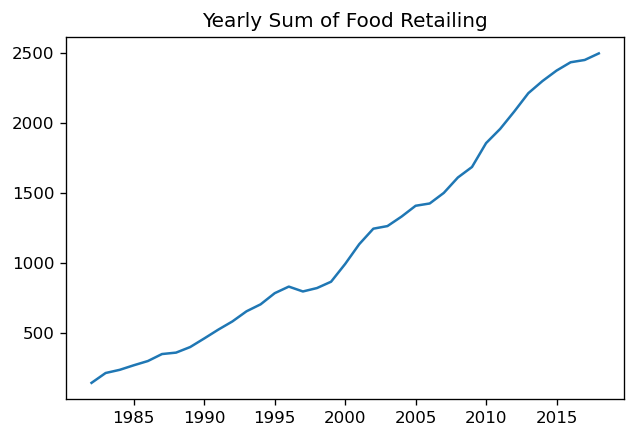

In [32]:
df['year']=pd.to_datetime(df.month).dt.year
#df.head()
fr = df.groupby('year')['food_retailing'].sum()
#fr.head()
plt.plot(fr.index, fr.values)
plt.title('Yearly Sum of Food Retailing')

### Task 2: Use the Augmented Dickey–Fuller Test at alpha=0.05 to find out if this timeseries is stationary. If it is not, use the ARIMA framework to locate a proper order of differencing (d) to reach stationarity. Report the Augmented Dickey–Fuller Test once you've succeded.

In [33]:
frdf = pd.DataFrame(fr)
frdf.head()

,food_retailing
year,
1982,147.8
1983,218.0
1984,240.6
1985,273.1
1986,303.3


In [14]:
from statsmodels.tsa.stattools import adfuller

#serires=fr.values
series=frdf['food_retailing']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.548309
p-value: 0.999064
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623


p-value of 99.91%. Therefore, can't reject the null hypothesis. Time-series highly likely not to be stationary.

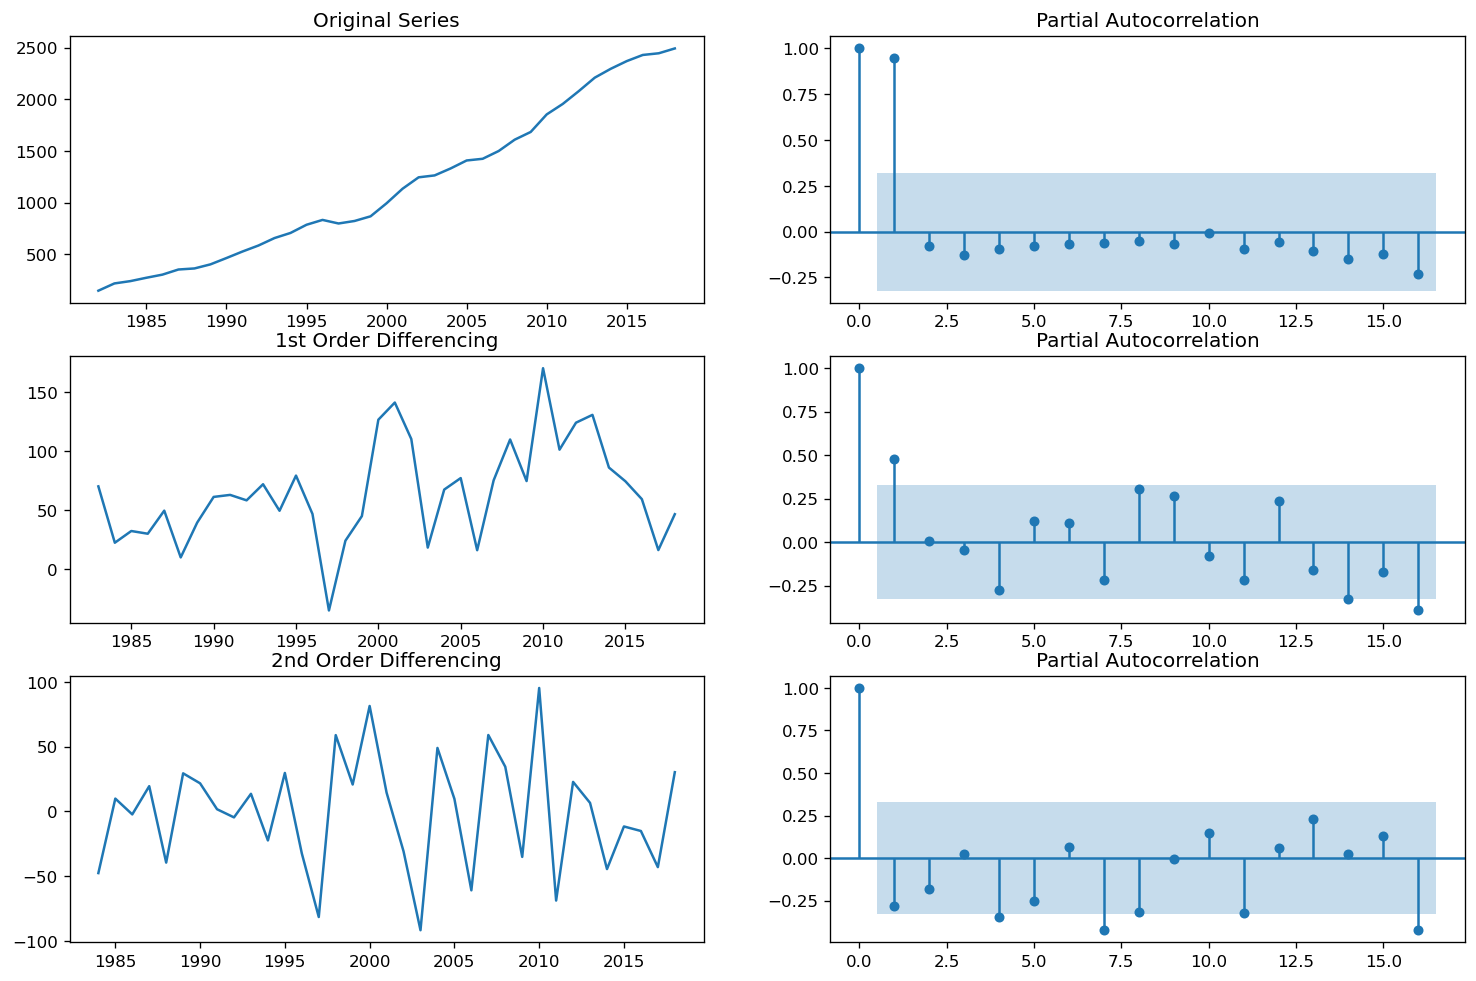

In [15]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(frdf.food_retailing); axes[0, 0].set_title('Original Series')
plot_pacf(frdf.food_retailing, ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(frdf.food_retailing.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(frdf.food_retailing.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(frdf.food_retailing.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(frdf.food_retailing.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation')

plt.show()

In [16]:
# raw
series=frdf['food_retailing']#.diff()
result = adfuller(series.dropna())
print('raw observations:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

# first order differencing
series=frdf['food_retailing'].diff()
result = adfuller(series.dropna())
print('\n1st order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

# second order differencing
series=frdf['food_retailing'].diff().diff()
result = adfuller(series.dropna())
print('\n2nd order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

raw observations:
  ADF Statistic: 2.548309
  p-value: 0.999064

1st order differencing:
  ADF Statistic: -3.444382
  p-value: 0.009536

2nd order differencing:
  ADF Statistic: -2.936616
  p-value: 0.041253


After first order differencing, ADF statistic and p-value are lower than critical value and significant value (0.05). Therefore, time series is now stationary. For forecasting, the number of differencing of ARIMA model will be 1(d).

### Task 3: Examine the PACF and ACF plots. What AR and/or MA orders would you choose if any?

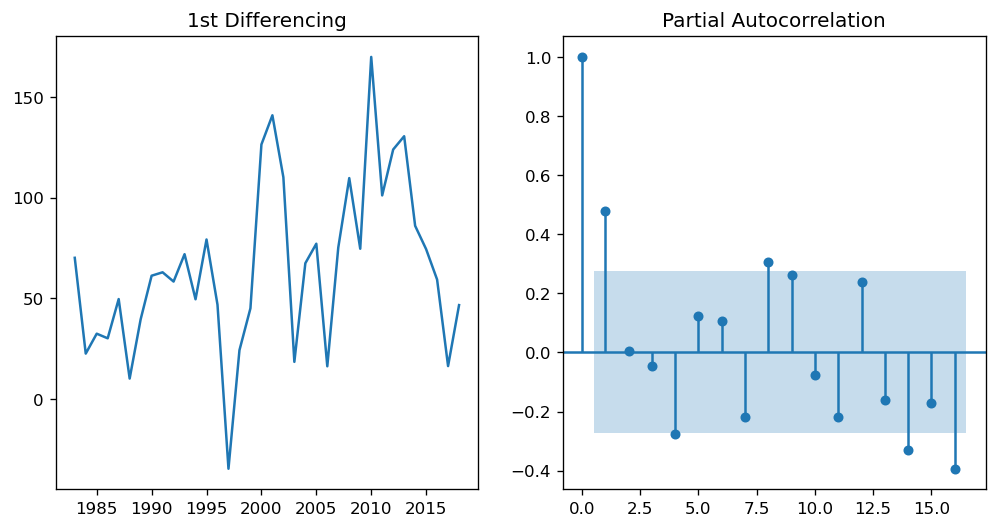

In [17]:
#AR
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(frdf.food_retailing.diff())
axes[0].set_title('1st Differencing')
# axes[1].set_ylim(0,1)
plot_pacf(frdf.food_retailing.diff().dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations

plt.show()

The PACF cuts off sharply at lag 1. Suggest AR term, Q=1.

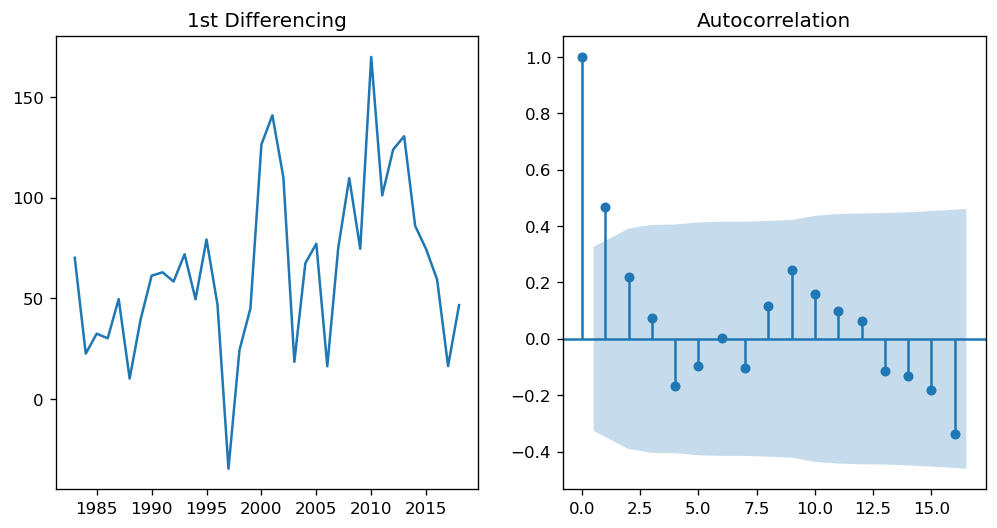

In [19]:
#MA
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(frdf.food_retailing.diff()); axes[0].set_title('1st Differencing')
plot_acf(frdf.food_retailing.diff().dropna(), ax=axes[1])

plt.show()

Along with significant cutoff in PACF plot, a noticeable/clear drop in the ACF plot after the first lag. Suggest MA term, P=1.

### Task 4: Train a model on the first 30 datapoints using an ARIMA(1,1,1) then predict on the last that 30-datapoint training set as well as the last 7 data points. Report and comment on residual diagnostics for both train and test periods, including MAE, RSME, PACF, ACF, a normality test, and a formal autocorrelation test (e.g., Ljung–Box test).

In [157]:
#df['date']=pd.to_datetime(df['month'], format='%d-%m-%Y')
#df['y-m'] = df['date'].dt.to_period('M')
#df.head()
#ndf = df[['y-m','food_retailing']]
#ndf = ndf.set_index('y-m')
#ndf.head()

,food_retailing
y-m,
1982-04,15.5
1982-05,15.1
1982-06,15.5
1982-07,16.1
1982-08,15.8


                               SARIMAX Results                                
Dep. Variable:         food_retailing   No. Observations:                   30
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -150.620
Date:                Mon, 28 Feb 2022   AIC                            307.240
Time:                        03:42:24   BIC                            311.342
Sample:                             0   HQIC                           308.525
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9917      0.037     26.998      0.000       0.920       1.064
ma.L1         -0.7771      0.186     -4.175      0.000      -1.142      -0.412
sigma2      1769.9083    442.308      4.002      0.0

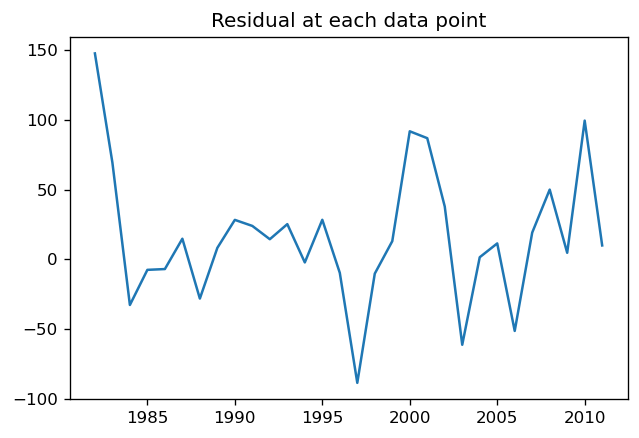

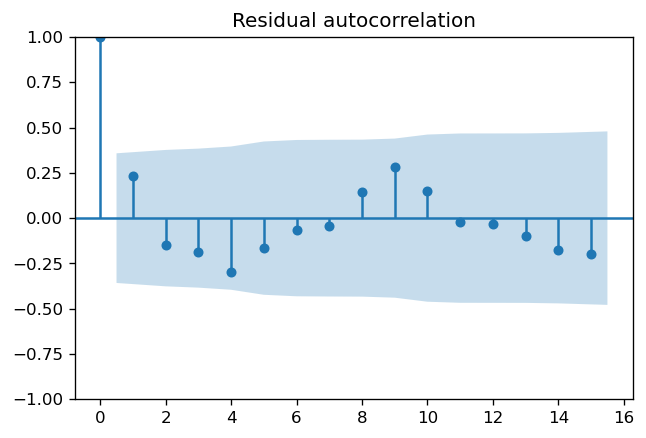

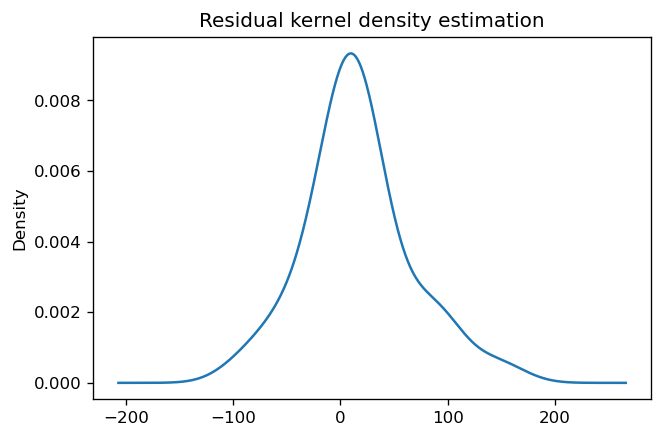

                0
count   30.000000
mean    16.266874
std     48.825874
min    -88.646861
25%     -7.398261
50%     12.233217
75%     28.372690
max    147.800000
p value is  0.17614754072613492
null hypothesis: residuals come from a normal distribution
The null hypothesis cannot be rejected
Ljung–Box:
    lb_stat  lb_pvalue
1  1.758331   0.184833
2  2.495772   0.287111
3  3.757632   0.288853
4  7.028119   0.134410
5  8.093675   0.151148
6  8.257999   0.219804


In [168]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

P=1
D=1
Q=1

# fit model
N=30   
series = frdf['food_retailing']#.values

#model = sm.tsa.SARIMAX(series[:N], order=(Q,D,P))
model = sm.tsa.ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

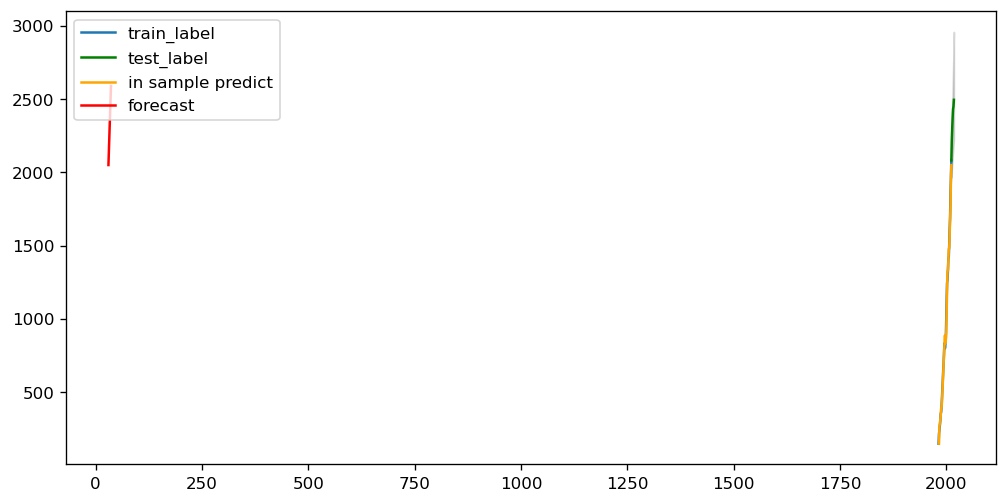

In [174]:
# Forecast

fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()

fc_series = pd.Series(fc['mean'], index=range(N,len(series)))
#mean_series = pd.Series(fc['mean'], index=range(N,len(series)))
lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(frdf.index[:N+1],series[:N+1],label='train_label') # train
ax.plot(frdf.index[N:],series[N:],color='green',label='test_label') # test
ax.plot(frdf.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(frdf.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf
ax.legend(loc='upper left')

In [182]:
# train
X = pd.DataFrame(range(N),columns=['food_retailing'])
X = sm.add_constant(X)
lm=sm.OLS(frdf.values[:N],X).fit()
insample = lm.predict(X)
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1062.
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           8.27e-24
Time:                        04:08:29   Log-Likelihood:                -175.34
No. Observations:                  30   AIC:                             354.7
Df Residuals:                      28   BIC:                             357.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             30.1254     30.812      0.

In [185]:
#test
X = pd.DataFrame(range(N-1,len(frdf)),columns=['food_retailing'])
X = sm.add_constant(X)
pred = lm.predict(X)

In [172]:
# compare out-of-sample performance
print('ARIMA model out-of-sample MAE', mean_absolute_error(frdf.values[N:],fc_series))
print('trend model out-of-sample MAE', mean_absolute_error(frdf.values[N-1:],pred))

ARIMA model out-of-sample MAE 54.741166020463815
trend model out-of-sample MAE 323.6260418984067


In [177]:
print('ARIMA model out-of-sample RSME', sqrt(mean_squared_error(frdf.values[N:],fc_series)))
print('trend model out-of-sample RSME', sqrt(mean_squared_error(frdf.values[N-1:],pred)))

ARIMA model out-of-sample RSME 59.477305269169705
trend model out-of-sample RSME 328.66168139231974


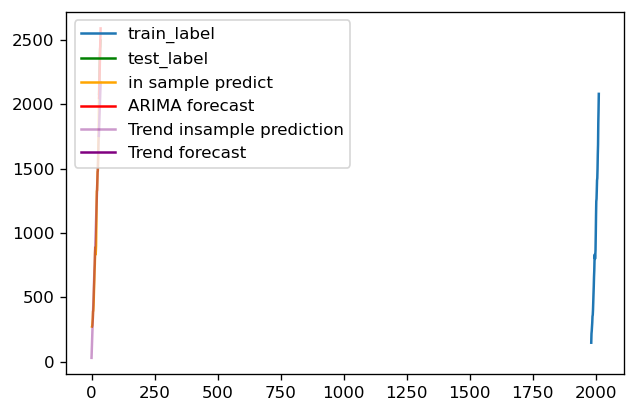

In [173]:
plt.plot(frdf['food_retailing'][:N+1],label='train_label')
plt.plot(range(N,len(frdf)),frdf['food_retailing'][N:],color='green',label='test_label')
plt.plot(range(P+D,N+1),model_fit.predict(start=P+D,end=N,dynamic=False,typ='levels'),color='orange',label='in sample predict')
plt.plot(fc_series, label='ARIMA forecast', color='red')

plt.plot(insample, label='Trend insample prediction', color='purple',alpha=0.4)
plt.plot(range(N-1,len(frdf)),pred, label='Trend forecast', color='purple')

plt.legend(loc='upper left')

# Homework 2: Using ARIMA model to predict a one-direction random walk.

### Task 1: Generate a one-dimensional additive random walk that starts at 0, with subsequent up/down steps at equal probability. Simulate 1000 steps and visualize the result. Use random seed 1234.

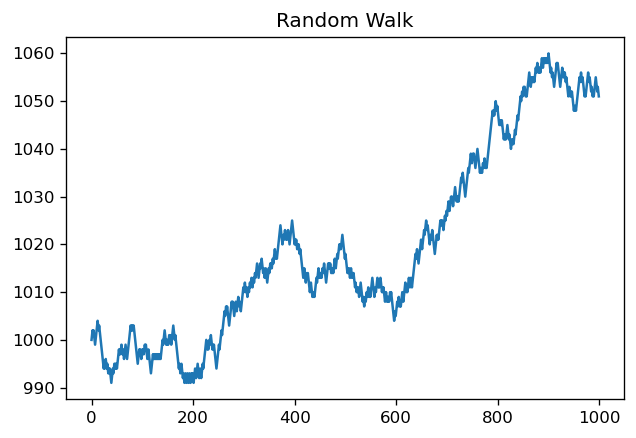

In [90]:
# Simple Application 1: A Random Walk.

# Set an arbitrary starting point and iterate the system using a simple Markov process.
# Each second, this process can move up 1 or it can move down, which it does at random.
# Pr(up) = Pr(down) = 0.5.

# pos is starting position.
# draws are random integers, {0, 1}.
# step is -1 if random draw is 0 and +1 if random draw is 1.
# walk is the vector containing each step.

np.random.seed(1234)

pos = 1000  
walk = [pos] # walk is the array that tracks the random path
nsteps = 1000 # establishs number of random steps
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 # Bernoulli draw to step "up" or "down"
    pos += step
    walk.append(pos)

plt.plot(walk[0:1000])
plt.title('Random Walk')
plt.show();

### Task 2: Make the series stationary. Report results from Augmented Dickey–Fuller Test at alpha=0.05.

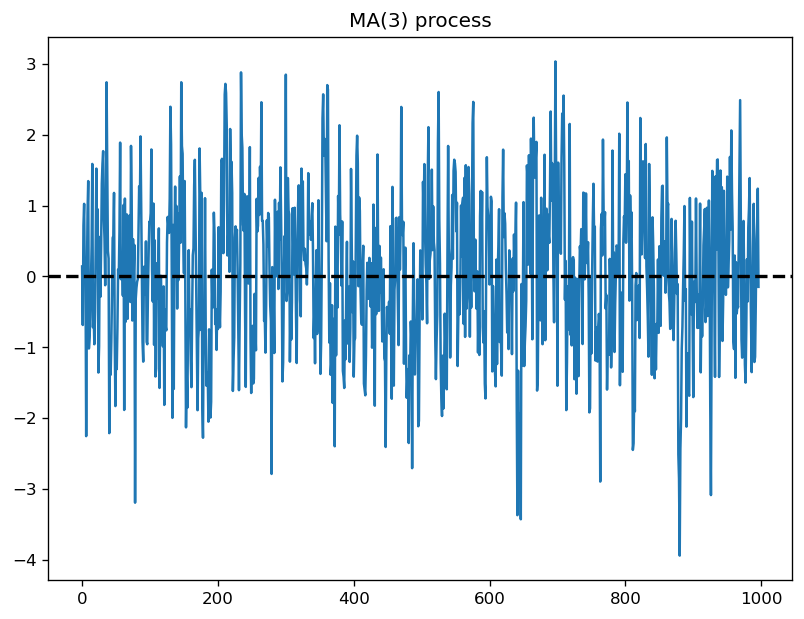

In [111]:
plt.rcParams.update({'figure.figsize':(10,5)})
T = 1000
p = 3
#generating and visualizing MA(3) process
theta=[1, 0.5, 0.3, 0.2]
np.random.seed(1234)
y=np.random.normal(0, 1, T)
x=0
for k in range(0,p+1):
    x=x+theta[k]*y[range(p-k,T-k)]
plt.figure(figsize = (8, 6))
plt.plot(x)
#plt.ylim(-4, 4)
plt.title('MA(3) process')
plt.axhline(0, color='k', ls='--', lw=2)
plt.show();

In [112]:
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.620009
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


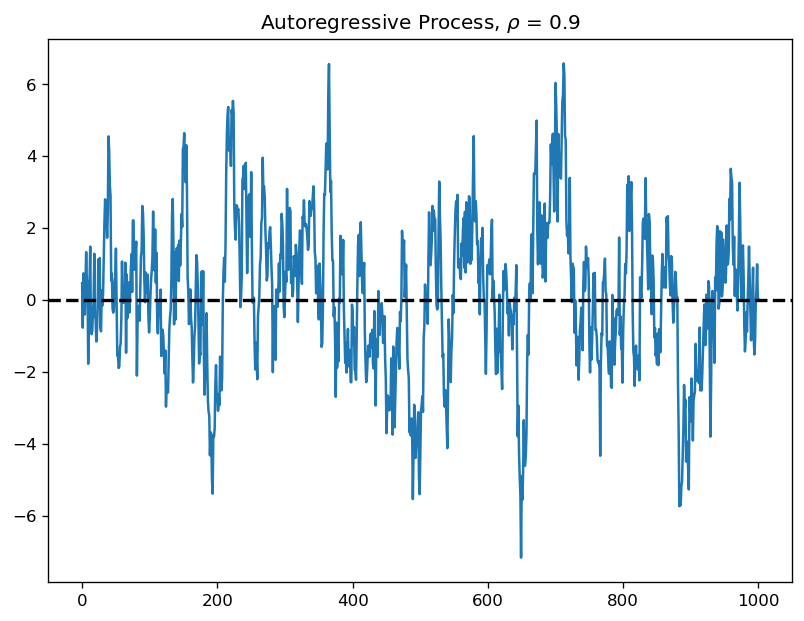

In [113]:
np.random.seed(1234)
#generating and visualizing AR(1) process
T = 1000
rho = 0.9
x = np.zeros(T+1)

x[0] = np.random.normal(0, 1)

for t in range(1, T):
    x[t] = rho * x[t-1] + np.random.normal(0, 1)

r = rho
plt.figure(figsize = (8, 6))
plt.plot(x)
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r))
plt.axhline(0, color='k', ls='--', lw=2)
plt.show();

In [114]:
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.094081
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


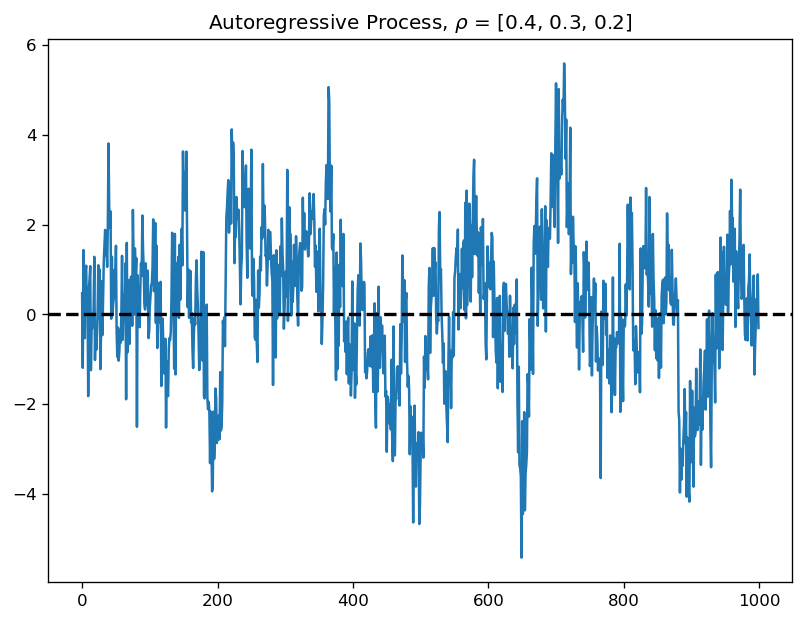

In [128]:
np.random.seed(1234)
#generating and visualizing AR(3) process
T = 1000
rho = [0.4, 0.3, 0.2]
x = np.zeros(T+1)

x = np.random.normal(0, 1, 3)

for t in range(3, T):
    x=np.append( x, rho [0] * x[t-1] + rho [1] * x[t-2] + rho [2] * x[t-3] + np.random.normal(0, 1))

r = rho
plt.figure(figsize = (8, 6))
plt.plot(x)
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r))
plt.axhline(0, color='k', ls='--', lw=2)
plt.show()

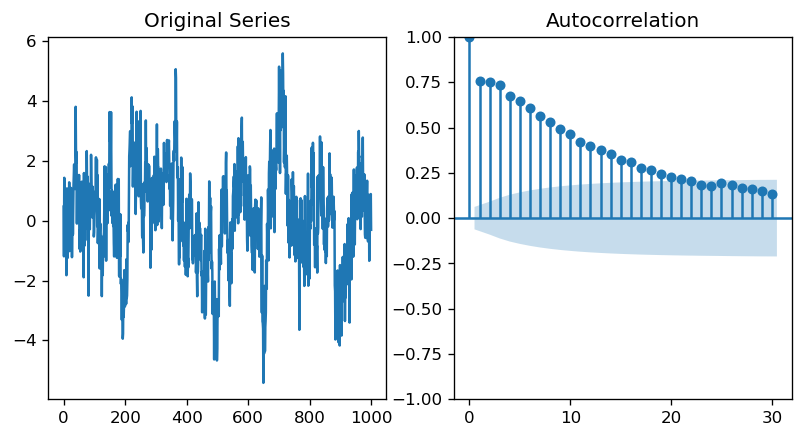

ADF Statistic: -5.390887
p-value: 0.000004
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [129]:
fig, axes = plt.subplots(1, 2,figsize=(8,4))
axes[0].plot(x)
axes[0].set_title('Original Series')
plot_acf(x, ax=axes[1])
plt.show()

result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [120]:
"""
Random generation of Gaussian ARMA(p,q) time series from http://stats.stackexchange.com/questions/37437/random-generation-of-arma2-2-gaussian-time-series

INPUTS

phi:      An array of length p with the AR coefficients (the AR part of 
          the ARMA model).

theta:    An array of length q with the MA coefficients (the MA part of 
          the ARMA model).

sigma:    Standard deviaton of the Gaussian noise.

n:        Length of the returned time-series.

burnin:   Number of datapoints that are going to be discarded (the higher 
          the better) to avoid dependence of the ARMA time-series on the 
          initial values.
""" 

from numpy.random import normal
from numpy import *
def ARMAgenerator(phi,theta,sigma,n,burnin=0,verbose=0):
    l=max(len(phi),len(theta))
    if(burnin==0):
        burnin=10*l # Burn-in elements!
    w=normal(0,sigma,n+burnin)
    ARMA=array([])
    s=0.0
    l=max(len(phi),len(theta))
    for i in range(n+burnin):
        if(i<l):
            ARMA=append(ARMA,w[i])
        else:
            s=0.0
            for j in range(len(phi)):
                s=s+phi[j]*ARMA[i-j-1]
            for j in range(len(theta)):
                s=s+theta[j]*w[i-j-1]
        ARMA=append(ARMA,s+w[i])
    if(verbose!=0):
        print ('Measured standard deviation: '+str(sqrt(var(w[burnin:]))))
    return ARMA[burnin:]

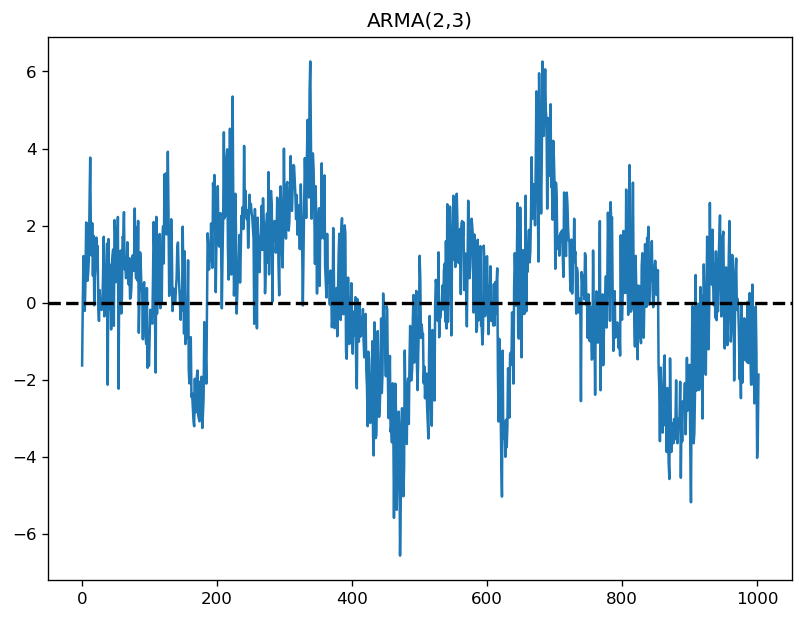

In [121]:
random.seed(1234)
x=ARMAgenerator([0.5, 0.4],[0.4,0.3,0.2],1,1000)
plt.figure(figsize = (8, 6))
plt.plot(x)
plt.title(r'ARMA(2,3)')
plt.axhline(0, color='k', ls='--', lw=2)
plt.show();

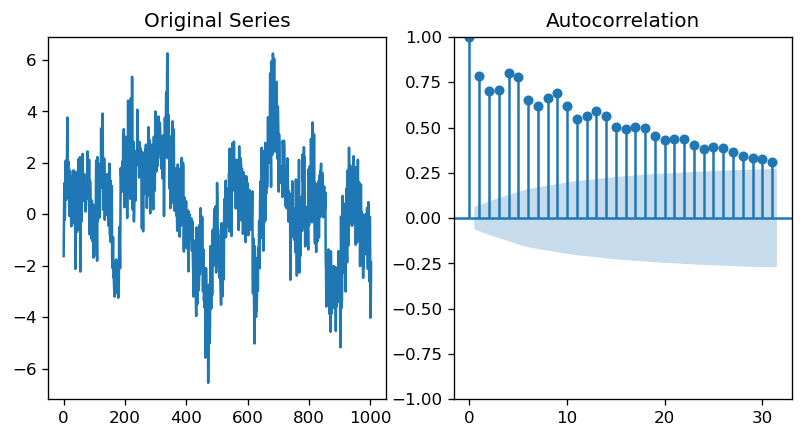

ADF Statistic: -3.604239
p-value: 0.005680
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [122]:
fig, axes = plt.subplots(1, 2,figsize=(8,4))
axes[0].plot(x)
axes[0].set_title('Original Series')
plot_acf(x, ax=axes[1])
plt.show()

result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

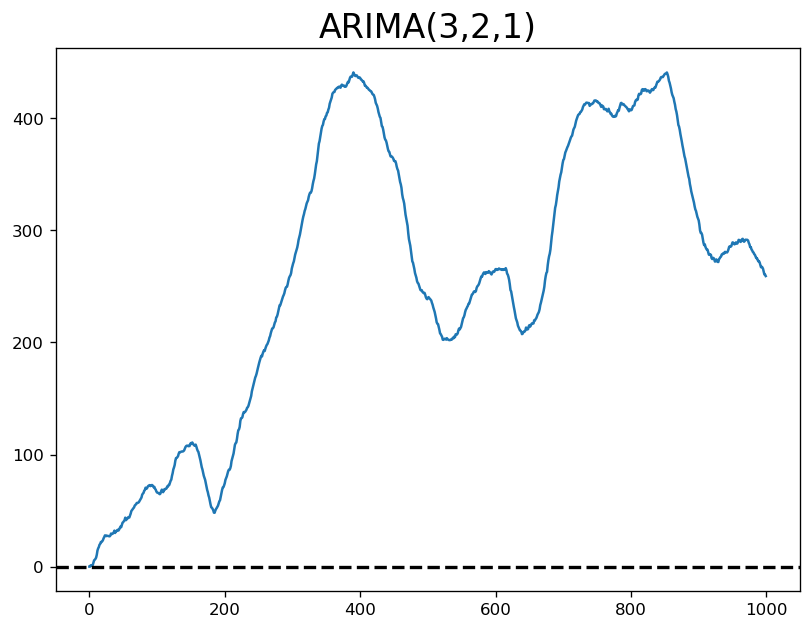

In [125]:
T = 1000
x1=[0]
for t in range(1, T):
    x1=np.append( x1, x1[t-1] + x[t])

plt.figure(figsize = (8, 6))
plt.plot(x1)
plt.title(r'ARIMA(3,2,1)', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)
plt.show();

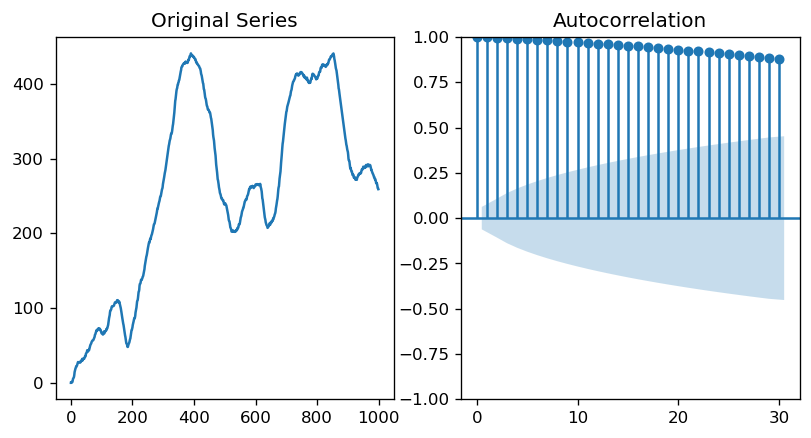

ADF Statistic: -2.222875
p-value: 0.198048
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [126]:
fig, axes = plt.subplots(1, 2,figsize=(8,4))
axes[0].plot(x1)
axes[0].set_title('Original Series')
plot_acf(x1, ax=axes[1])
plt.show()

result = adfuller(x1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### Task 3: Difference the series and plot their PACF and ACFs. What do you notice?

In [143]:
np.random.seed(1234)
#generating and visualizing AR(3) process
T = 1000
rho = [0.4, 0.3, 0.2]
x = np.zeros(T+1)

x = np.random.normal(0, 1, 3)

for t in range(3, T):
    x=np.append( x, rho [0] * x[t-1] + rho [1] * x[t-2] + rho [2] * x[t-3] + np.random.normal(0, 1))

result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.390887
p-value: 0.000004
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


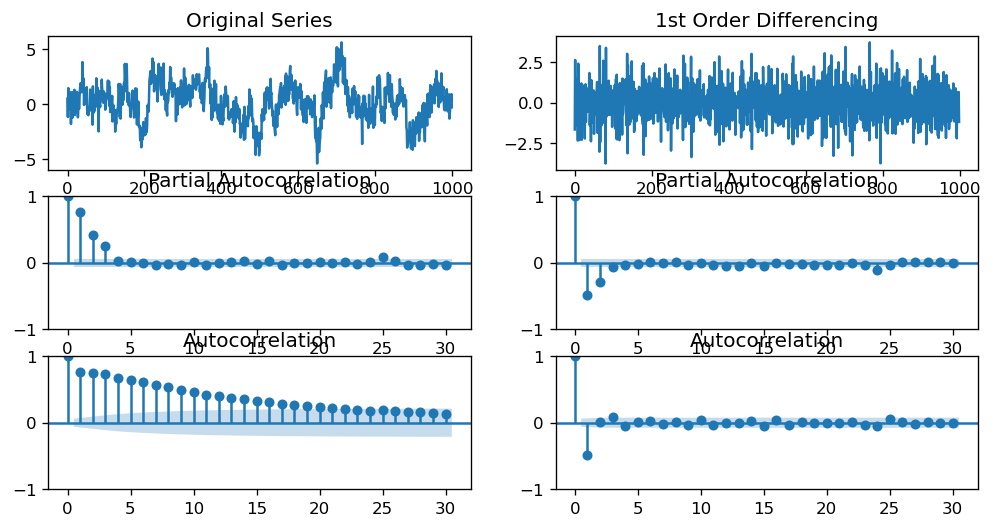

In [144]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(x); axes[0, 0].set_title('Original Series')
axes[0, 1].plot(np.diff(x)); axes[0, 1].set_title('1st Order Differencing')

#PACF
plot_pacf(x, ax=axes[1, 0])
#axes[1, 0].set_title('Partial Autocorrelation')
plot_pacf(np.diff(x), ax=axes[1, 1])
#axes[1, 1].set_title('Partial Autocorrelation')

#ACF
plot_acf(x, ax=axes[2, 0])
#axes[2, 0].set_title('Autocorrelation')
plot_acf(np.diff(x), ax=axes[2, 1])
#axes[2, 1].set_title('Autocorrelation')

plt.show()